In [1]:
# rsync -av -e 'ssh -o ProxyCommand="ssh -q -W %h:%p s2016765@ssh.inf.ed.ac.uk"' s2016765@mlp.inf.ed.ac.uk:/home/s2016765/final_project/experiments/resnet50_aircraft_224_224 experiments/
# for file in ~/final_project/exp_scripts/*.out; do echo "File: $file"; tail -n 2 "$file"; echo; echo; done

import os
import random

import torch
import timm
from PIL import Image
import cv2
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vit_b_16, ViT_B_16_Weights, ResNet50_Weights

from cub2011 import Cub2011

/home/posiedon72/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download Bird dataset into data/ folder by setting download=True. 
# The 'train_data' variable won't be used later in the code, it's just there to download the dataset.

train_data = Cub2011(root='data', train=True, download=False)

# Accuracy and loss

In [3]:
epoch_dict = {'resnet50_im_224': 100,
              'resnet50_im21_224': 100, 
              'vitb16_im_224': 64, 
              'vitb16_im21_224': 78, 
              'resnet50_base_224': 94, 
              'vitb16_base_224': 74, 
              'resnet50_im_100': 85, 
              'resnet50_im21_100': 96, 
              'vitb16_im_100': 42, 
              'vitb16_im21_100': 68, 
              'resnet50_base_100': 30, 
              'vitb16_base_100': 84
 }

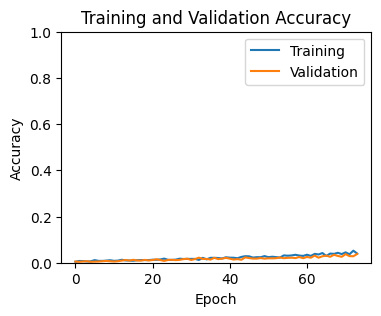

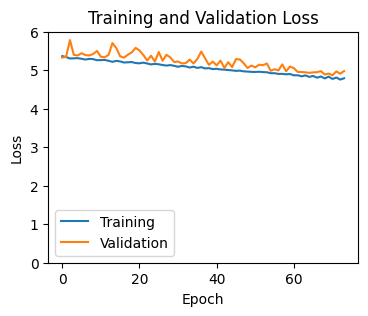

In [4]:

# Read the CSV file
df = pd.read_csv('test.csv')

# Plotting the training and validation accuracy
plt.figure(figsize=(4, 3))
plt.plot(df['train_acc'], label='Training')
plt.plot(df['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(4, 3))
plt.plot(df['train_loss'], label='Training')
plt.plot(df['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 6)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Image transformation testing

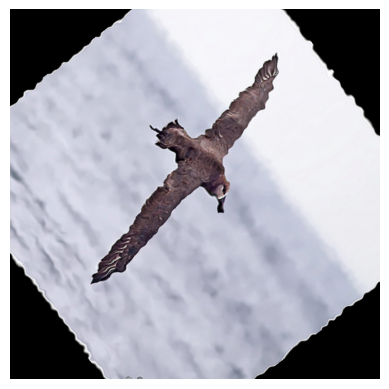

In [5]:
# Testing the effects of transformations

# Define transformations
transform = transforms.Compose([
    transforms.Resize((768, 768), interpolation=Image.BICUBIC),  # Resize to 224x224
    # transforms.CenterCrop(75),  # Crop to 224x224 at the center
    # transforms.Resize((512, 512), interpolation=Image.BICUBIC),
    # transforms.ElasticTransform(125.0),
    transforms.RandomRotation(180),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Path to your image
image_path = "data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg"

# Load and apply transformations
image = Image.open(image_path)
transformed_tensor = transform(image)

# Reverse normalization and convert tensor to PIL image
reverse_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
reverse_transform = transforms.Compose([transforms.Normalize((0, 0, 0), (1, 1, 1)), transforms.ToPILImage()])
transformed_image = reverse_transform(reverse_normalize(transformed_tensor))

# Display the transformed image
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

# Retrieve model

The functions below can be used to retrieve the best model for the specified model: ['resnet50', 'vitb16'], pre-training scheme: ['im', 'im21', 'base'], and resolutions: [100, 224] 

In [6]:
def load_weights(model, state):
    for key in model.state_dict():
        if 'num_batches_tracked' in key:
            continue
        p = model.state_dict()[key]
        if 'model.module.' + key in state['network']:
            ip = state['network']['model.module.' + key]
            if p.shape == ip.shape:
                p.data.copy_(ip.data)  # Copy the data of parameters
            else:
                print(
                    'could not load layer: {}, mismatch shape {} ,{}'.format(key, (p.shape), (ip.shape)))
        else:
            print('could not load layer: {}, not in checkpoint'.format(key))
    return model

In [26]:
def get_model(model_name, pretrain_scheme, res, num_classes=None):
    directory = f'experiments/{model_name}_{pretrain_scheme}_{res}'
    # Get all file names in the directory
    file_names = os.listdir(directory)

    # Filter file names that start with 'train_model'
    filtered_file_names = [file_name for file_name in file_names if file_name.startswith('train_model')]
    model_path = os.path.join(directory, filtered_file_names[-1])
    print(f'Loading model from {model_path}')
    state = torch.load(model_path, map_location=torch.device('cpu'))
    if model_name == 'resnet50':
        model = resnet50()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model = load_weights(model, state)
    elif model_name == 'vitb16':
        if pretrain_scheme in ['im', 'base']:
            model = vit_b_16()
            model.heads[0].out_features = num_classes
            model = load_weights(model, state)
        elif pretrain_scheme == 'im21':
            model_kwargs = dict(
            patch_size=16, embed_dim=768, depth=12, num_heads=12, qkv_bias=False)
            model = timm.models.vision_transformer._create_vision_transformer('vit_base_patch16_224_in21k',
                                                                            pretrained=False,
                                                                            num_classes=num_classes, **model_kwargs)
            model.load_state_dict(state_dict=state['network'])
    
    print(f'Loaded {model_name}_{pretrain_scheme}_{res}')
    return model

class_dict = {'birds': 200, 'aircraft': 100}

# Gradient visualisation

In [27]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
def get_processed_images(im_path, res=224):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(im_path))
    img = cv2.resize(img, (res, res))
    rgb_img_float = np.float32(img) / 255
    transform = transforms.Compose([
        # transforms.CenterCrop(0.875 * res),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    input_tensor = transform(rgb_img_float).unsqueeze(0)
    return img, rgb_img_float, input_tensor

In [28]:
def get_random_images(num_images=5):
    image_dir = "data/CUB_200_2011/images/"
    image_paths = []

    # Traverse all directories in the image directory
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            # Get the full path of each image file
            image_path = os.path.join(root, file)
            image_paths.append(image_path)

    # Select 5 random image paths
    image_paths = random.sample(image_paths, num_images)
    return image_paths


In [29]:
def get_image_grads(image_paths, model_name, pretrain_scheme, res, num_classes):
    model = get_model(model_name=model_name, pretrain_scheme=pretrain_scheme, res=res, num_classes=num_classes)
    if model_name == 'resnet50':
        target_layers = [model.layer4[-1]]
    elif model_name == 'vitb16':
        target_layers = [model.encoder.ln]
    image_grads = []
    for image_path in image_paths:
        img, img_float, input_tensor = get_processed_images(image_path, res=res)
        
        concept_features = model(input_tensor)[0, :]
        targets = [SimilarityToConceptTarget(concept_features)]
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        cam_image = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)
        image_grads.append(cam_image)
    return image_grads

In [31]:
image_grads = get_image_grads(get_random_images(), model_name='resnet50', pretrain_scheme='base', res=100, num_classes=class_dict['birds'])

Loading model from experiments/resnet50_base_100/train_model_30


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

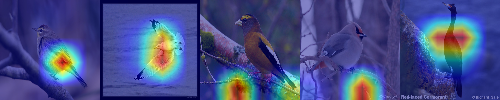

In [25]:
Image.fromarray(np.hstack(image_grads))